# Stage 09 — Homework Starter Notebook

In the lecture, we learned how to create engineered features. Now it’s your turn to apply those ideas to your own project data.

In [12]:
import pandas as pd
import numpy as np

# Example synthetic data (replace with your project dataset)
# np.random.seed(0)
# n = 100
# df = pd.DataFrame({
#     'income': np.random.normal(60000, 15000, n).astype(int),
#     'monthly_spend': np.random.normal(2000, 600, n).astype(int),
#     'credit_score': np.random.normal(680, 50, n).astype(int)
# })
# df.head()

# Import my own dataset
from pathlib import Path
path = Path('../../../project/data/raw')
data_path = path / "original.csv"
variables_path = path / "variable_name.csv"
data = pd.read_csv(data_path)
variables = pd.read_csv(variables_path)

mapping = dict(zip(variables['Attribute'], variables['Description']))
data.rename(columns=mapping, inplace=True)
print(data.info())
print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## TODO: Implement at least 2 engineered features here

In [19]:
# Feature 1: Credit amount to income ratio (proxy: credit_amount / (age * employment length))
# Since we don't have income, we use age * employment_since as a rough proxy for earning power
# First, map employment_since to numeric (A71: unemployed, A72: <1yr, A73: 1-4yr, A74: 4-7yr, A75: >=7yr)
employment_map = {'A71': 0, 'A72': 0.5, 'A73': 2.5, 'A74': 5.5, 'A75': 8}
data['employment_years'] = data['employment_since'].map(employment_map)
data['credit_to_income_proxy'] = data['credit_amount'] / (data['age'] * (data['employment_years'] + 1))

# Feature 2: Young with high credit (binary: age < 25 and credit_amount > median)
data['young_high_credit'] = ((data['age'] < 25) & (data['credit_amount'] > data['credit_amount'].median())).astype(int)

data[['credit_to_income_proxy', 'young_high_credit']].head()

,credit_to_income_proxy,young_high_credit
0,1.938640,0
1,77.285714,1
2,6.580848,0
3,26.947009,0
4,26.253369,0


### Rationale for Feature 1
Explain why this feature may help a model. Reference your EDA.

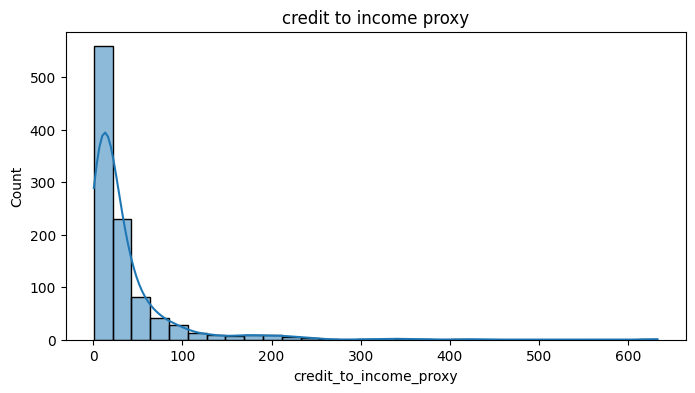

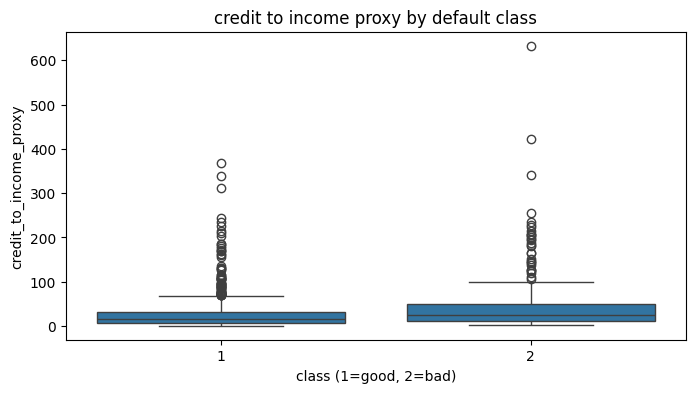

mean of credit_to_income_proxy by default class:
class
1    28.866981
2    46.246382
Name: credit_to_income_proxy, dtype: float64


In [ ]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(data['credit_to_income_proxy'], bins=30, kde=True)
plt.title('credit to income proxy')
plt.xlabel('credit_to_income_proxy')
plt.ylabel('Count')
plt.show()

# Segregate by default 
plt.figure(figsize=(8, 4))
sns.boxplot(x='class', y='credit_to_income_proxy', data=data)
plt.title('credit to income proxy by default class')
plt.xlabel('class (1=good, 2=bad)')
plt.ylabel('credit_to_income_proxy')
plt.show()

# Calculate mean of different default group
group_means = data.groupby('class')['credit_to_income_proxy'].mean()
print("mean of credit_to_income_proxy by default class:")
print(group_means)

Conclusion: The EDA supports the hypothesis. Customers with a higher credit_to_income_proxy have a higher risk of default, making this feature valuable for risk prediction.


### Rationale for Feature 2
Explain why this feature may help a model. Reference your EDA.

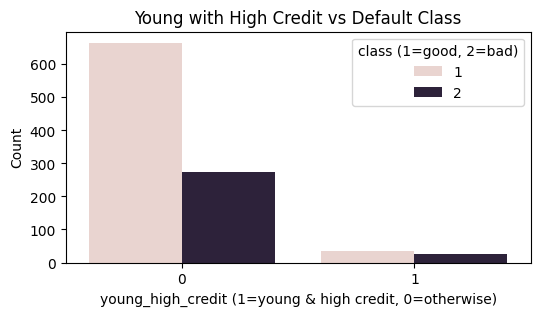

Default rate by young_high_credit group:
class                     1         2
young_high_credit                    
0                  0.708955  0.291045
1                  0.564516  0.435484


In [18]:
# EDA for Feature 2: young_high_credit

plt.figure(figsize=(6, 3))
sns.countplot(x='young_high_credit', hue='class', data=data)
plt.title('Young with High Credit vs Default Class')
plt.xlabel('young_high_credit (1=young & high credit, 0=otherwise)')
plt.ylabel('Count')
plt.legend(title='class (1=good, 2=bad)')
plt.show()

# Calculate default rate for young_high_credit groups
default_rate = data.groupby('young_high_credit')['class'].value_counts(normalize=True).unstack()
print("Default rate by young_high_credit group:")
print(default_rate)

* Conclusion: The hypothesis is supported. The default rate (class=2) for the group with young_high_credit=1 is significantly higher than for other groups, indicating that young customers with high credit amounts are at greater risk.
* Significance: This variable helps the model identify high-risk young customers and improves risk prediction capability.